# 上涨敲出看涨期权（Up-and-Out Call）蒙特卡洛定价

## 2.1 模型方程
在风险中性测度下，3/2随机波动率模型由以下随机微分方程定义：

$$
\Large
\begin{aligned}
dS_t &= rS_t dt + \sqrt{V_t}S_t dW_t \\
dV_t &= \kappa(\theta V_t - V_t^2) dt + \lambda V_t^{3/2} dB_t \\
d\langle W, B\rangle_t &= \rho dt
\end{aligned}
$$

**参数解释：**
- $ S_t $: 标的资产价格
- $ V_t $: 方差过程（波动率的平方）
- $ r $: 无风险利率
- $ \kappa $: 均值回归速度
- $ \theta $: 长期方差水平
- $ \lambda $: 方差波动率（vol-of-vol）
- $ \rho $: 价格与方差过程的相关系数
- $ W_t, B_t $: 相关的布朗运动

### 2.1.1 模型特点
- **方差过程非线性**：漂移项包含$ V_t^2 $，扩散项为$ V_t^{3/2} $
- **确保正性**：方差过程$ V_t $保持正性，符合金融直觉
- **杠杆效应**：通常$ \rho < 0 $，价格下跌时波动率上升
- **厚尾分布**：能更好地拟合实际资产收益分布的尖峰厚尾特征

## 2.2 数值模拟实现

### 2.2.1 欧拉离散化方案
对于均匀时间网格$ t_0 < t_1 < \cdots < t_N $，其中$ \Delta t = T/N $：

$$
\Large
\begin{aligned}
V_{t_{n+1}} &= V_{t_n} + \kappa(\theta V_{t_n} - V_{t_n}^2)\Delta t + \lambda V_{t_n}^{3/2} \sqrt{\Delta t} Z_{n}^{(2)} \\
S_{t_{n+1}} &= S_{t_n} + rS_{t_n}\Delta t + \sqrt{V_{t_n}} S_{t_n} \sqrt{\Delta t} Z_{n}^{(1)}
\end{aligned}
$$

其中相关随机变量生成：
$$
\Large
\begin{aligned}
Z_{n}^{(1)} &= G_n \\
Z_{n}^{(2)} &= \rho G_n + \sqrt{1-\rho^2} H_n
\end{aligned}
$$

$ G_n, H_n \sim \mathcal{N}(0,1) $独立同分布。

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [6]:
def simulate_32_sv_paths_euler(S0, V0, r, kappa, theta, lam, rho, T, N, M):
    """
    使用欧拉离散化方法模拟3/2随机波动率模型的路径
    
    参数:
    S0: 初始资产价格
    V0: 初始方差
    r: 无风险利率
    kappa: 均值回归速度
    theta: 长期方差水平
    lam: 方差波动率 (vol-of-vol)
    rho: 价格与方差的相关系数
    T: 总时间长度（年）
    N: 时间步数
    M: 模拟的路径数量
    
    返回:
    t: 时间点数组，形状为 (N+1,)
    S: 资产价格路径矩阵，形状为 (N+1, M)
    V: 方差路径矩阵，形状为 (N+1, M)
    """
    t = np.linspace(0, T, N + 1)
    dt = T / N
    sqrt_dt = np.sqrt(dt)
    
    S = np.zeros((N + 1, M))
    V = np.zeros((N + 1, M))
    S[0, :] = S0
    V[0, :] = V0
    
    G = norm.rvs(size = (N, M))
    H = norm.rvs(size = (N, M))
    
    Z_S = G
    Z_V = rho * G + np.sqrt(1 - rho ** 2) * H
    
    for n in tqdm.tqdm(range(N), desc="Simulating 3/2 SV paths", unit="step"):
        V_n = np.maximum(V[n, :], 1e-10)
        
        drift_V = kappa * (theta * V_n - V_n ** 2) * dt
        diffusion_V = lam * (V_n ** 1.5) * sqrt_dt * Z_V[n, :]
        V[n + 1, :] = V_n + drift_V + diffusion_V
        
        drift_S = r * S[n, :] * dt
        diffusion_S = np.sqrt(V_n) * S[n, :] * sqrt_dt * Z_S[n, :]
        S[n + 1, :] = S[n, :] + drift_S + diffusion_S
        
    return t, S, V


In [7]:
def compute_up_and_out_call_payoff_sv(S_path, K, B):
    """
    计算上涨敲出看涨期权的payoff（适用于随机波动率模型）
    
    参数:
    S_path: 资产价格路径矩阵，形状为 (N+1, M)
    K: 执行价格
    B: 障碍价格（需满足 S0 < B）
    
    返回:
    payoff: 每条路径的payoff，形状为 (M,)
    """
    max_prices = np.max(S_path, axis = 0)
    final_prices = S_path[-1, :]
    
    payoffs = np.where(max_prices < B, np.maximum(final_prices - K, 0), 0)
    
    return payoffs
    

In [8]:
def price_up_and_out_call_sv_monte_carlo(S0, V0, K, B, T, r, kappa, theta, lam, rho, M, N, confidence_level = 0.99):
    """
    使用蒙特卡洛方法在3/2随机波动率模型下定价上涨敲出看涨期权
    
    参数:
    S0: 初始资产价格
    V0: 初始方差
    K: 执行价格
    B: 障碍价格（需满足 S0 < B）
    T: 到期时间（年）
    r: 无风险利率
    kappa: 均值回归速度
    theta: 长期方差水平
    lam: 方差波动率 (vol-of-vol)
    rho: 价格与方差的相关系数
    M: 蒙特卡洛模拟路径数
    N: 时间步数
    confidence_level: 置信水平（默认0.99）
    
    返回:
    dict: 包含价格估计、置信区间等信息的字典
    """
    # 1. 模拟3/2随机波动率模型路径
    t, S_paths, V_paths = simulate_32_sv_paths_euler(S0, V0, r, kappa, theta, lam, rho, T, N, M)
    
    # 2. 计算每条路径的payoff
    payoffs = compute_up_and_out_call_payoff_sv(S_paths, K, B)
    
    # 3. 贴现payoff
    discount_factor = np.exp(-r * T)
    discounted_payoffs = payoffs * discount_factor
    
    # 4. 计算统计量
    price_estimate = np.mean(discounted_payoffs)
    price_std = np.std(discounted_payoffs, ddof = 1)
    price_se = price_std / np.sqrt(M)
    
    # 5. 计算置信区间
    z_value = norm.ppf((1 + confidence_level) / 2)
    ci_half_width = z_value * price_se
    ci_lower = price_estimate - ci_half_width
    ci_upper = price_estimate + ci_half_width
    
    return {
        'price_estimate': price_estimate,
        'price_std': price_std,
        'price_se': price_se,
        'confidence_interval': (ci_lower, ci_upper),
        'confidence_level': confidence_level,
        'discounted_payoffs': discounted_payoffs,
        'S_paths': S_paths,
        'V_paths': V_paths,
        'time_grid': t
    }

In [9]:
def plot_sv_paths_with_barrier(t, S_paths, V_paths, B, num_paths_to_plot=20):
    """
    绘制随机波动率模型路径并标出障碍水平
    
    参数:
    t: 时间网格
    S_paths: 资产价格路径矩阵
    V_paths: 方差路径矩阵
    B: 障碍价格
    num_paths_to_plot: 要绘制的路径数量
    """
    M = S_paths.shape[1]
    num_paths = min(num_paths_to_plot, M)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # 绘制资产价格路径
    for i in range(num_paths):
        max_price = np.max(S_paths[:, i])
        color = 'red' if max_price >= B else 'blue'
        alpha = 0.3 if max_price >= B else 0.1
        ax1.plot(t, S_paths[:, i], color=color, alpha=alpha, linewidth=0.5)
    
    # 绘制障碍线
    ax1.axhline(y=B, color='green', linestyle='--', linewidth=2, label=f'Barrier B = {B}')
    
    # 绘制初始价格线
    ax1.axhline(y=S_paths[0, 0], color='black', linestyle=':', linewidth=1.5, 
                label=f'Initial Price S0 = {S_paths[0, 0]}')
    
    ax1.set_xlabel('Time (years)', fontsize=12)
    ax1.set_ylabel('Asset Price', fontsize=12)
    ax1.set_title(f'3/2 Stochastic Volatility Model - Price Paths (B={B})', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 绘制波动率路径（标准差）
    for i in range(num_paths):
        vol_path = np.sqrt(V_paths[:, i])
        max_price = np.max(S_paths[:, i])
        color = 'red' if max_price >= B else 'blue'
        alpha = 0.3 if max_price >= B else 0.1
        ax2.plot(t, vol_path, color=color, alpha=alpha, linewidth=0.5)
    
    ax2.set_xlabel('Time (years)', fontsize=12)
    ax2.set_ylabel('Volatility (σ)', fontsize=12)
    ax2.set_title(f'3/2 Stochastic Volatility Model - Volatility Paths', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [10]:
def analyze_sv_sensitivity_to_M(S0, V0, K, B, T, r, kappa, theta, lam, rho, N, M_list):
    """
    分析随机波动率模型下期权价格对蒙特卡洛模拟路径数M的敏感性
    
    参数:
    M_list: 模拟路径数的列表
    其他参数同 price_up_and_out_call_sv_monte_carlo
    """
    price_estimates = []
    ci_lowers = []
    ci_uppers = []
    standard_errors = []
    
    for M in tqdm.tqdm(M_list, desc="SV Sensitivity to M"):
        results = price_up_and_out_call_sv_monte_carlo(
            S0, V0, K, B, T, r, kappa, theta, lam, rho, M, N
        )
        price_estimates.append(results['price_estimate'])
        ci_lowers.append(results['confidence_interval'][0])
        ci_uppers.append(results['confidence_interval'][1])
        standard_errors.append(results['price_se'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 图1：价格和置信区间
    ax1.plot(M_list, price_estimates, 'b-', linewidth=2, label='Price Estimate')
    ax1.fill_between(M_list, ci_lowers, ci_uppers, alpha=0.2, color='blue', label='99% CI')
    ax1.set_xscale('log')
    ax1.set_xlabel('Number of Monte Carlo Simulations (M)', fontsize=12)
    ax1.set_ylabel('Option Premium', fontsize=12)
    ax1.set_title('3/2 SV Model: Price Estimate vs. M', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 图2：标准误差
    ax2.plot(M_list, standard_errors, 'r-', linewidth=2)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Number of Monte Carlo Simulations (M)', fontsize=12)
    ax2.set_ylabel('Standard Error (log scale)', fontsize=12)
    ax2.set_title('3/2 SV Model: Standard Error vs. M', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'M_values': M_list,
        'price_estimates': price_estimates,
        'confidence_intervals': list(zip(ci_lowers, ci_uppers)),
        'standard_errors': standard_errors
    }

In [11]:
def analyze_sv_sensitivity_to_N(S0, V0, K, B, T, r, kappa, theta, lam, rho, M, N_list):
    """
    分析随机波动率模型下期权价格对时间步数N的敏感性
    
    参数:
    N_list: 时间步数的列表
    其他参数同 price_up_and_out_call_sv_monte_carlo
    """
    price_estimates = []
    
    for N in tqdm.tqdm(N_list, desc="SV Sensitivity to N"):
        results = price_up_and_out_call_sv_monte_carlo(
            S0, V0, K, B, T, r, kappa, theta, lam, rho, M, N
        )
        price_estimates.append(results['price_estimate'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(N_list, price_estimates, 'g-o', linewidth=2, markersize=8)
    plt.xlabel('Number of Time Steps (N)', fontsize=12)
    plt.ylabel('Option Premium', fontsize=12)
    plt.title(f'3/2 SV Model: Sensitivity to Discretization (M={M})', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'N_values': N_list,
        'price_estimates': price_estimates
    }
    

In [12]:
def analyze_sv_sensitivity_to_lambda(S0, V0, K, B, T, r, kappa, theta, rho, M, N, lambda_list):
    """
    分析随机波动率模型下期权价格对方差波动率λ的敏感性
    
    参数:
    lambda_list: 方差波动率λ的列表
    其他参数同 price_up_and_out_call_sv_monte_carlo
    """
    price_estimates = []
    
    for lam in tqdm.tqdm(lambda_list, desc="SV Sensitivity to λ"):
        results = price_up_and_out_call_sv_monte_carlo(
            S0, V0, K, B, T, r, kappa, theta, lam, rho, M, N
        )
        price_estimates.append(results['price_estimate'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(lambda_list, price_estimates, 'm-o', linewidth=2, markersize=8)
    plt.xlabel('Volatility-of-Volatility (λ)', fontsize=12)
    plt.ylabel('Option Premium', fontsize=12)
    plt.title(f'3/2 SV Model: Sensitivity to λ (M={M}, N={N})', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'lambda_values': lambda_list,
        'price_estimates': price_estimates
    }


In [13]:
def analyze_sv_sensitivity_to_rho(S0, V0, K, B, T, r, kappa, theta, lam, M, N, rho_list):
    """
    分析随机波动率模型下期权价格对相关系数ρ的敏感性
    
    参数:
    rho_list: 相关系数ρ的列表
    其他参数同 price_up_and_out_call_sv_monte_carlo
    """
    price_estimates = []
    
    for rho in tqdm.tqdm(rho_list, desc="SV Sensitivity to ρ"):
        results = price_up_and_out_call_sv_monte_carlo(
            S0, V0, K, B, T, r, kappa, theta, lam, rho, M, N
        )
        price_estimates.append(results['price_estimate'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(rho_list, price_estimates, 'c-o', linewidth=2, markersize=8)
    plt.xlabel('Correlation (ρ)', fontsize=12)
    plt.ylabel('Option Premium', fontsize=12)
    plt.title(f'3/2 SV Model: Sensitivity to ρ (M={M}, N={N})', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'rho_values': rho_list,
        'price_estimates': price_estimates
    }

In [14]:
def run_sv_comprehensive_analysis():
    """
    运行3/2随机波动率模型的综合测试分析
    """
    # 基础参数设置（与项目要求一致）
    S0 = 100
    V0 = 0.20
    K = 100
    B = 120  # 障碍价格（S0 < B）
    T = 1.0
    r = 0.05
    
    # 3/2模型参数
    kappa = 0.20
    theta = 0.20
    lam = 0.67
    rho = -0.5
    
    print("=" * 70)
    print("UP-AND-OUT CALL OPTION - 3/2 STOCHASTIC VOLATILITY MODEL")
    print("=" * 70)
    print(f"Price Parameters: S0={S0}, K={K}, B={B}, T={T}, r={r}")
    print(f"3/2 SV Parameters: V0={V0}, κ={kappa}, θ={theta}, λ={lam}, ρ={rho}")
    print()
    
    # 1. 单次定价示例
    print("1. Single Pricing Example:")
    print("-" * 40)
    
    M = 10000
    N = 252  # 假设交易日数
    
    results = price_up_and_out_call_sv_monte_carlo(
        S0, V0, K, B, T, r, kappa, theta, lam, rho, M, N
    )
    
    print(f"   Monte Carlo Paths: M = {M}")
    print(f"   Time Steps: N = {N}")
    print(f"   Price Estimate: {results['price_estimate']:.4f}")
    print(f"   Standard Error: {results['price_se']:.6f}")
    print(f"   {int(results['confidence_level']*100)}% Confidence Interval: [{results['confidence_interval'][0]:.4f}, {results['confidence_interval'][1]:.4f}]")
    print()
    
    # 2. 绘制路径示例
    print("2. Visualizing Sample Paths:")
    print("-" * 40)
    
    # 用小M快速生成路径用于可视化
    t, sample_S_paths, sample_V_paths = simulate_32_sv_paths_euler(
        S0, V0, r, kappa, theta, lam, rho, T, 100, 200
    )
    plot_sv_paths_with_barrier(t, sample_S_paths, sample_V_paths, B, num_paths_to_plot=50)
    
    # 3. 对M的敏感性分析
    print("3. Sensitivity Analysis to M (Number of Simulations):")
    print("-" * 40)
    
    M_list = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
    M_sensitivity = analyze_sv_sensitivity_to_M(
        S0, V0, K, B, T, r, kappa, theta, lam, rho, N, M_list
    )
    
    # 4. 对N的敏感性分析
    print("4. Sensitivity Analysis to N (Number of Time Steps):")
    print("-" * 40)
    
    N_list = [10, 25, 50, 100, 252, 500, 1000]
    N_sensitivity = analyze_sv_sensitivity_to_N(
        S0, V0, K, B, T, r, kappa, theta, lam, rho, M, N_list
    )
    
    # 5. 对方差波动率λ的敏感性分析
    print("5. Sensitivity Analysis to Volatility-of-Volatility (λ):")
    print("-" * 40)
    
    lambda_list = np.linspace(0.1, 1.5, 15)
    lambda_sensitivity = analyze_sv_sensitivity_to_lambda(
        S0, V0, K, B, T, r, kappa, theta, rho, M, N, lambda_list
    )
    
    # 6. 对相关系数ρ的敏感性分析
    print("6. Sensitivity Analysis to Correlation (ρ):")
    print("-" * 40)
    
    rho_list = np.linspace(-0.9, 0.9, 19)
    rho_sensitivity = analyze_sv_sensitivity_to_rho(
        S0, V0, K, B, T, r, kappa, theta, lam, M, N, rho_list
    )
    
    print()
    print("=" * 70)
    print("3/2 STOCHASTIC VOLATILITY MODEL ANALYSIS COMPLETE")
    print("=" * 70)
    
    return {
        'single_pricing': results,
        'M_sensitivity': M_sensitivity,
        'N_sensitivity': N_sensitivity,
        'lambda_sensitivity': lambda_sensitivity,
        'rho_sensitivity': rho_sensitivity,
    }

UP-AND-OUT CALL OPTION - 3/2 STOCHASTIC VOLATILITY MODEL
Price Parameters: S0=100, K=100, B=120, T=1.0, r=0.05
3/2 SV Parameters: V0=0.2, κ=0.2, θ=0.2, λ=0.67, ρ=-0.5

1. Single Pricing Example:
----------------------------------------


Simulating 3/2 SV paths: 100%|██████████| 252/252 [00:00<00:00, 3629.59step/s]


   Monte Carlo Paths: M = 10000
   Time Steps: N = 252
   Price Estimate: 0.2045
   Standard Error: 0.014138
   99% Confidence Interval: [0.1681, 0.2409]

2. Visualizing Sample Paths:
----------------------------------------


Simulating 3/2 SV paths: 100%|██████████| 100/100 [00:00<00:00, 27494.62step/s]


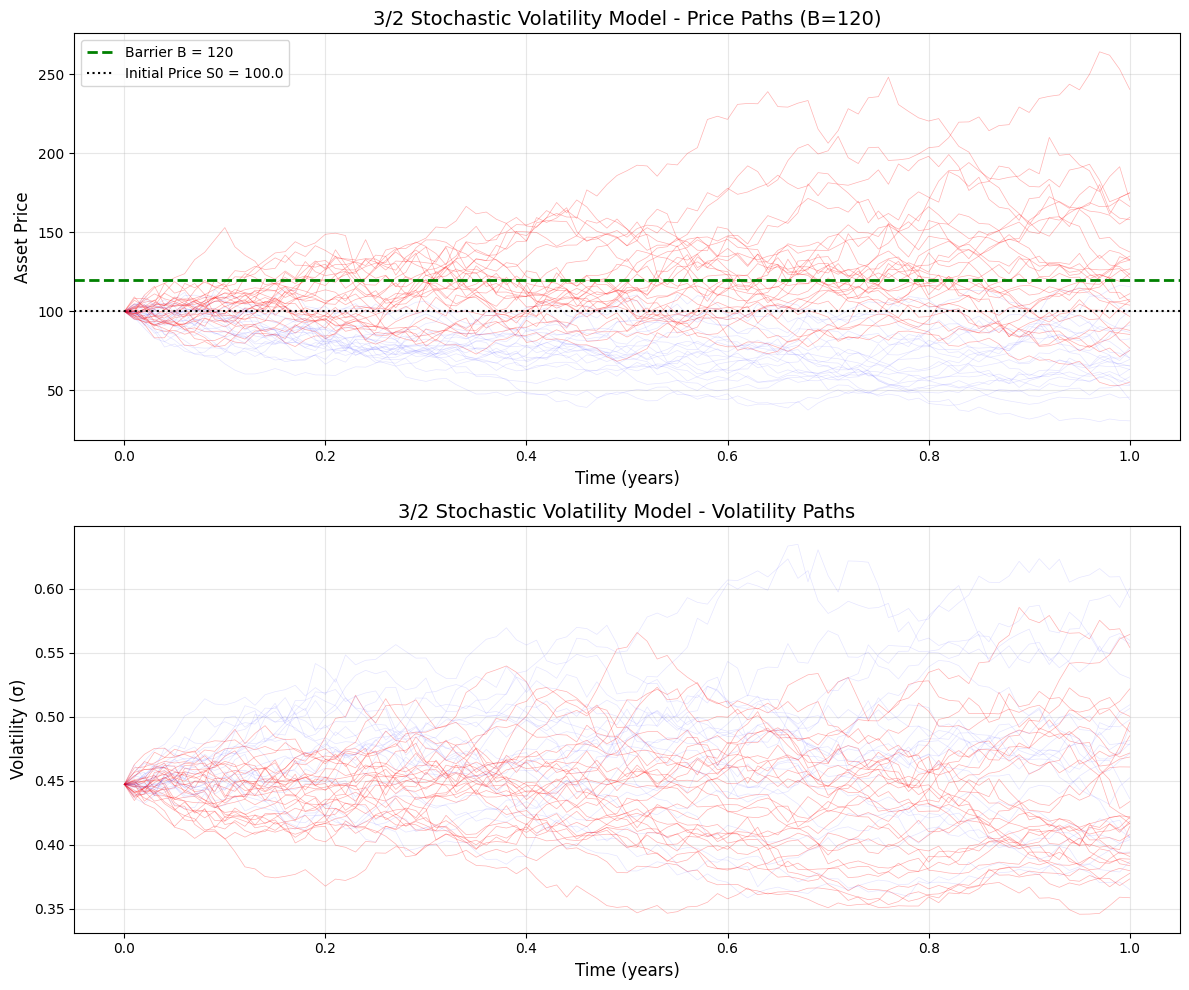

3. Sensitivity Analysis to M (Number of Simulations):
----------------------------------------


SV Sensitivity to M: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]


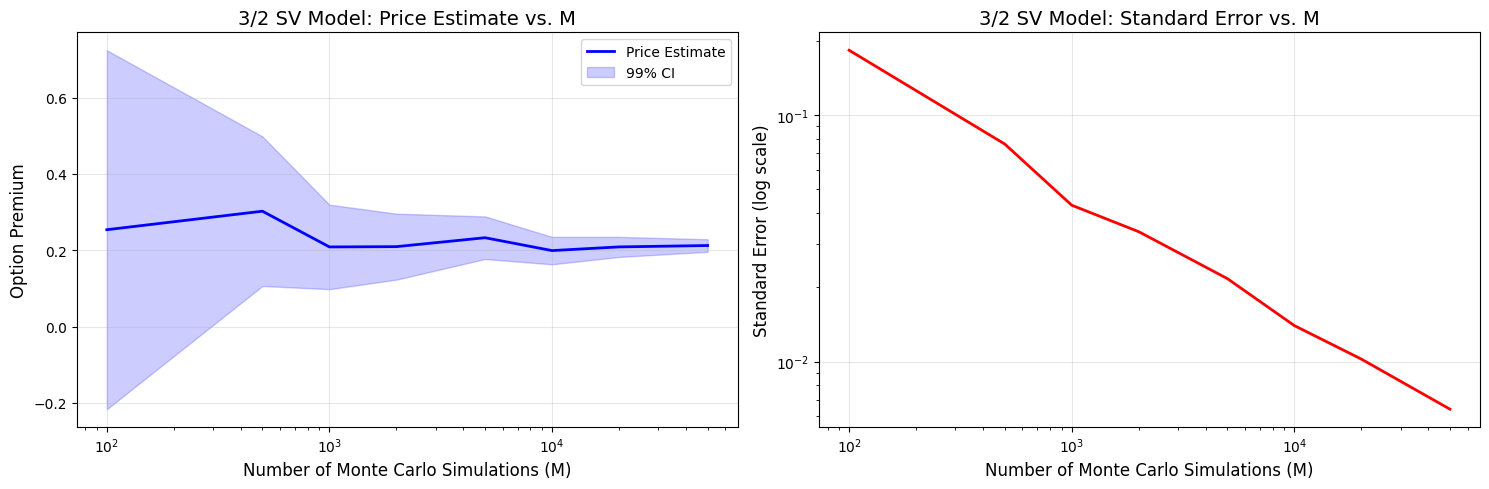

4. Sensitivity Analysis to N (Number of Time Steps):
----------------------------------------


SV Sensitivity to N: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


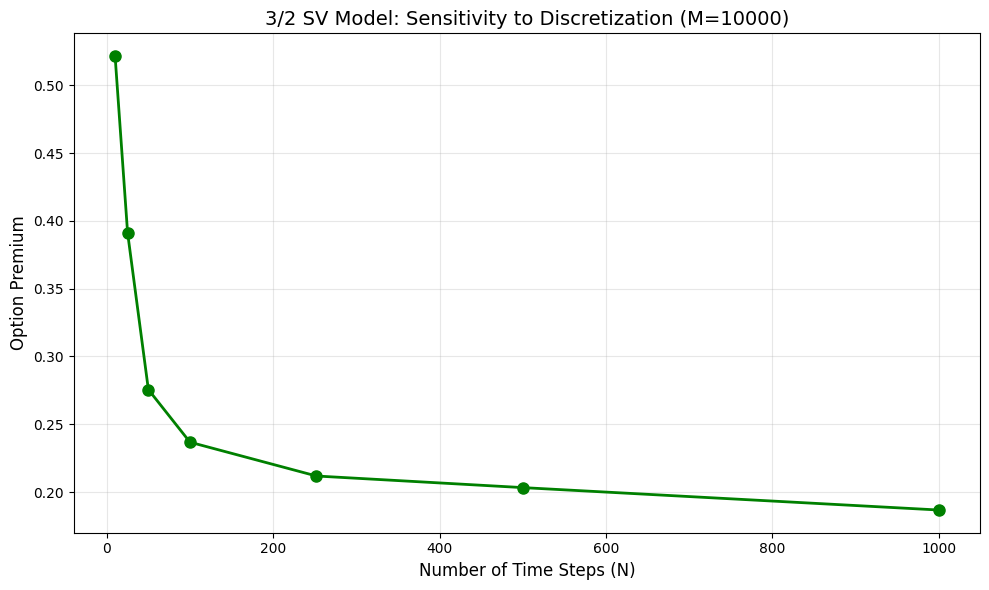

5. Sensitivity Analysis to Volatility-of-Volatility (λ):
----------------------------------------


SV Sensitivity to λ: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


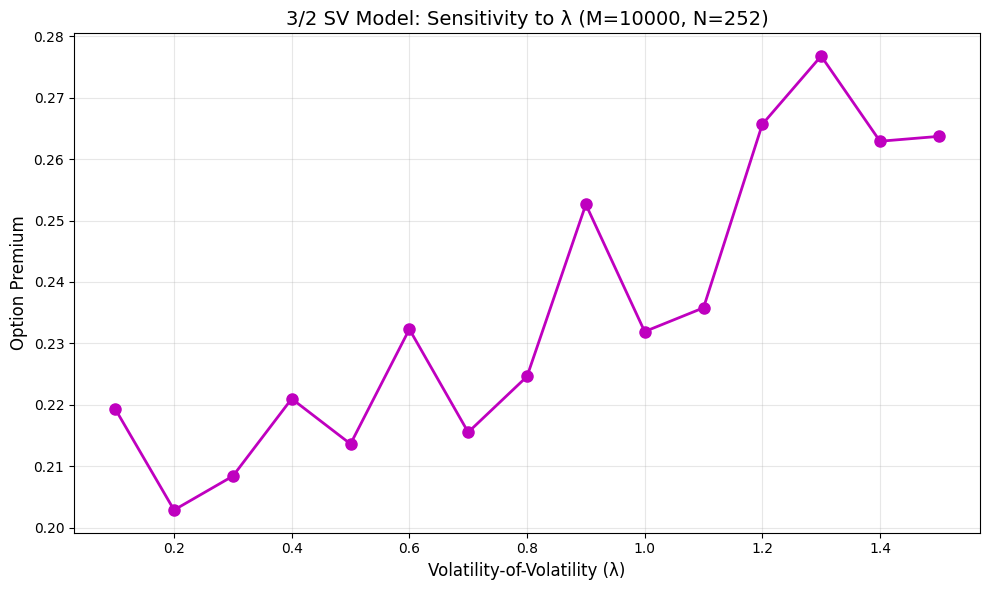

6. Sensitivity Analysis to Correlation (ρ):
----------------------------------------


SV Sensitivity to ρ: 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


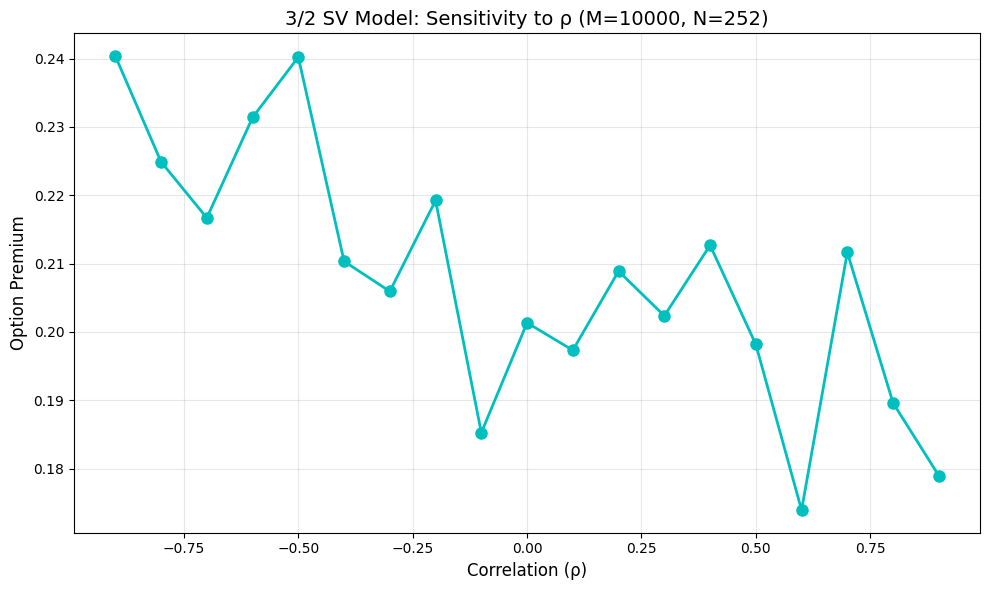


3/2 STOCHASTIC VOLATILITY MODEL ANALYSIS COMPLETE


In [15]:
if __name__ == "__main__":
    sv_analysis_results = run_sv_comprehensive_analysis()